In [ ]:
import numpy as np
from collections import Counter
import cv2
import os
import gc
from sklearn.linear_model import Perceptron

## Training procedure

1) Make a root node with whole training data and labels.

2) Train a perceptron with the node's X and Y, and predict the labels for X.

3) Partition the data with the predicted labels, all the samples with predicted label 0 goes into left child and with predicted label 1 goes to right child.

4) Store the model trained inside the node , which will be used while predicting for unknown data.

5) Train a new Perceptron in the child nodes and repeat from step 3.

**Stopping criteria**-

1) All the labels in the nodes are in same class.( No need of further splitting)

2) The perceptron is not able to seperate data into two classes. ( Either no left child or no right child)

**Reference-**

*https://ieeexplore.ieee.org/document/210172*

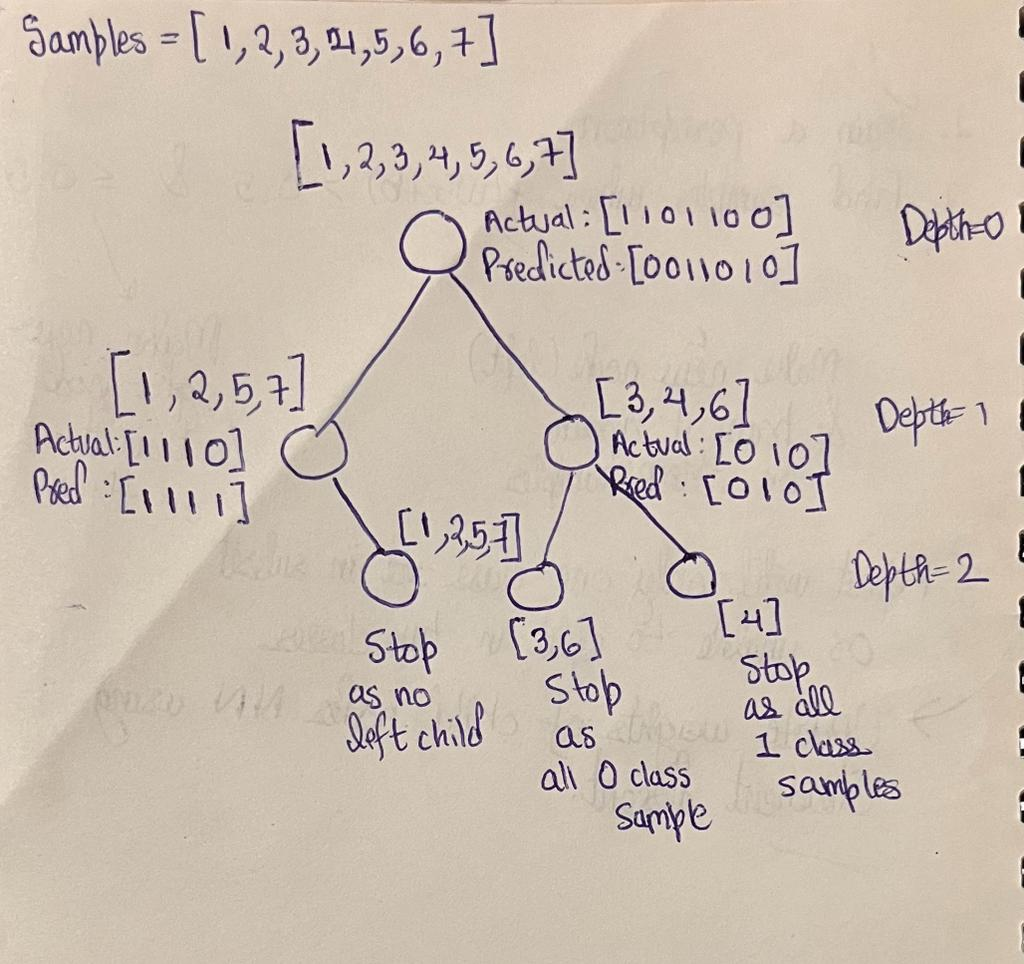

Node consists of -

1) X - image data

2) Y - image label

3) depth - node depth

4) model - perceptron

5) yhat - predicted labels

6) left - pointer to left child

7) right - pointer to right child

In [ ]:
class Node:
  def __init__(self,X,Y,depth):
    """
    Intitializing node values
    """
    # Saving the data to the node
    self.Y = Y  # labels for Image data
    self.X = X  # Image data
    self.depth = depth if depth else 0  # depth of the node from root
    self.model = None # Perceptron using X and Y
    self.yhat = None # prediction from Perceptron
    self.left = None # left child
    self.right = None # right child

    try:
      self.n = X.shape[1] # number of features
    except:
      self.n = 0

  def grow_tree(self):
    """
    Recursive method to create the decision tree of NN
    """

    print("Node at depth :", self.depth)

    c = Counter(self.Y)

    if c[0]==0 or c[1]==0:
      print("stopping as all samples in same class with Y : ", self.Y)
      # print(c[0]+c[1])
      return

    # train a perceptron
    clf = Perceptron()
    clf.fit(self.X,self.Y)
    self.yhat = clf.predict(self.X)

    # Storing model in the Node
    self.model = clf

    left_samples = []
    left_y = []
    right_samples = []
    right_y = []
    index = 0
    # Find samples where f(wt*x+b) >=0.5
    for pred in self.yhat:
      if pred==0:
        left_samples.append(self.X[index,:])
        left_y.append(self.Y[index])
      else:
        right_samples.append(self.X[index,:])
        right_y.append(self.Y[index])
      index+=1

    left_samples = np.array(left_samples)
    right_samples = np.array(right_samples)
    print("left ",left_samples.shape)
    print("right ",right_samples.shape)

    # make left
    left_node = Node(left_samples,left_y,self.depth+1)

    if(left_samples.shape[0]==0):
      print("Stopping as no left child!!")
      # print(len(right_y) - sum(np.array(right_y)^np.array(self.Y)))
      return
    if (right_samples.shape[0]==0):
      print("Stopping as no right child!!")
      # print(len(left_y) - sum(np.array(left_y)^np.array(self.Y)))
      return

    # assign left node of current node
    self.left = left_node
    # grow left subtree
    self.left.grow_tree()

    # make right
    right_node = Node(right_samples,right_y,self.depth+1)

    # assign left node of current node
    self.right = right_node
    # grow left subtree
    self.right.grow_tree()


  def predict(self, x) -> int:
    """
    Method to predict the class given a set of features
    """
    cur_node = self
    # Traversing the nodes all the way to the bottom
    while (cur_node!=None):

      if cur_node.model is None: # CASE: when the data consist of only one class
        break

      yhat = cur_node.model.predict(x)

      if (yhat==0):
        cur_node = cur_node.left
      else:
        cur_node = cur_node.right

    return yhat

In [ ]:
# Loading image data

dataset_dir = "/content/drive/MyDrive/Assignment data/"

data = []
labels = []
for data_folder in os.listdir(dataset_dir):
    category, data_label = data_folder.split("_")
    if(data_label == 'nonface'):
        label = 0
    else:
        label = 1
    count_label1 = 0
    for filename in os.listdir(dataset_dir + "/" + data_folder):
        merged_path = dataset_dir + "/" + data_folder + "/" + filename
        x = cv2.imread(merged_path)
        if(x is None):
            print(merged_path)

        x=cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        x = cv2.resize(x,(224,224))
        x = np.array(x,'float32')
        x /= 255
        data.append(x)
        labels.append(label)
        if(label==1):
          count_label1+=1

        if count_label1==1500:
          break

In [ ]:
X = np.array(data).reshape(3000,224*224)
y = np.array(labels)

Data consist of 1500 human face image and 1500 non human face images( animal face, vehicles, furniture)

Splitting data into train (70%) , validation(15%) and testing data (15%).

In [ ]:
from sklearn.model_selection import train_test_split

(train_x, rem_x, train_y, rem_y) = train_test_split(X, y,test_size=0.3, stratify=y, random_state=42)
(val_x, test_x, val_y, test_y) = train_test_split(rem_x, rem_y,test_size=0.5, stratify=rem_y, random_state=42)


In [ ]:
del data
del labels
del X
del y
del rem_x
del rem_y
gc.collect()

0

In [ ]:
train_x.shape

(2100, 50176)

In [ ]:
root = Node(train_x,train_y,0)
root.grow_tree()

Node at depth : 0
left  (1038, 50176)
right  (1062, 50176)
Node at depth : 1
left  (1030, 50176)
right  (8, 50176)
Node at depth : 2
left  (1027, 50176)
right  (3, 50176)
Node at depth : 3
left  (1026, 50176)
right  (1, 50176)
Node at depth : 4
left  (1011, 50176)
right  (15, 50176)
Node at depth : 5
left  (1006, 50176)
right  (5, 50176)
Node at depth : 6
left  (1005, 50176)
right  (1, 50176)
Node at depth : 7
left  (1005, 50176)
right  (0,)
Stopping as no right child!!
Node at depth : 7
stopping as all samples in same class with Y :  [1]
Node at depth : 6
left  (1, 50176)
right  (4, 50176)
Node at depth : 7
stopping as all samples in same class with Y :  [0]
Node at depth : 7
stopping as all samples in same class with Y :  [1, 1, 1, 1]
Node at depth : 5
stopping as all samples in same class with Y :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Node at depth : 4
stopping as all samples in same class with Y :  [1]
Node at depth : 3
left  (2, 50176)
right  (1, 50176)
Node at depth : 4


In [ ]:
# Accuracy on training data
from sklearn.metrics import accuracy_score
pred = []
for i in range(train_x.shape[0]):
  t = train_x[i,:]
  t = t.reshape(1,-1)
  # print(t.shape)
  prob = root.predict(t)
  if(prob==1):
    pred.append(1)
  else:
    pred.append(0)

print("Accuracy Score: ", accuracy_score(train_y,pred))

Accuracy Score:  0.9947619047619047


In [ ]:
# Accuracy on validation data
from sklearn.metrics import accuracy_score
pred = []
for i in range(val_x.shape[0]):
  t = val_x[i,:]
  t = t.reshape(1,-1)
  prob = root.predict(t)
  if(prob==1):
    pred.append(1)
  else:
    pred.append(0)
print("Accuracy Score: ", accuracy_score(val_y,pred))

Accuracy Score:  0.7822222222222223


In [ ]:
# Accuracy on testing data
from sklearn.metrics import accuracy_score
pred = []
for i in range(test_x.shape[0]):
  t = test_x[i,:]
  t = t.reshape(1,-1)
  prob = root.predict(t)
  if(prob==1):
    pred.append(1)
  else:
    pred.append(0)
print("Accuracy Score: ", accuracy_score(test_y,pred))

Accuracy Score:  0.8133333333333334


## Scheme to avoid Overfitting

Overfitting can be avoided if we decrease the depth of NN tree.

So not being very specific but generalizing for many samples in the leaf node rather than small samples.

We have to find the correct subtree of the node which can be replaced by the majority labels in that subtree.

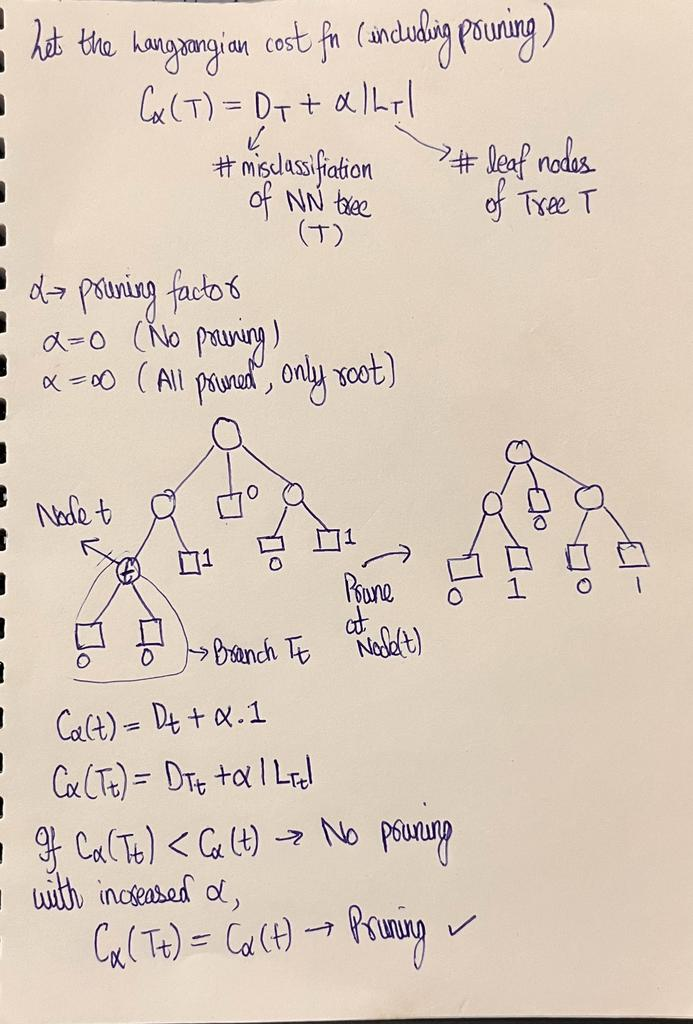